# NTDS assignment 3: spectral graph theory
[Michaël Defferrard](http://deff.ch), *PhD student*, [EPFL LTS2](http://lts2.epfl.ch)

The first two assignments were designed to warm you up. This third assignment is closer to what we expect you to do for the projects. It mainly misses the exploratory data analysis part (though there is some in sections 5.1 and 5.2). As such, our plan for this assignement encompasses data collection and exploitation, and goes as follows:
1. Data collection: use a web API to collect the musical genre of 2000 songs.
2. Feature extraction: compute features from audio tracks.
3. Graph construction: construct a nearest-neighbor graph from the features.
4. Eigendecomposition: factorization of the graph Laplacian (c.f. spectral graph theory).
5. Visualization & Clustering: using the graph and eigenvectors to visualize the dataset and to cluster the tracks.
6. Conclusion: a reflexion about what we did (though realisations are scattered all along).

The data we are using for this assignment is a subset of the [Free Music Archive dataset](https://github.com/mdeff/fma), a collection of 1TB of music with metadata released under a permissive license.

In [1]:
%matplotlib inline

import configparser
import os

import requests
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse, stats, spatial
import scipy.sparse.linalg
from sklearn import preprocessing, decomposition
import librosa
import IPython.display as ipd
from bs4 import BeautifulSoup as bs
plt.rcParams['figure.figsize'] = (17, 5)
plt.style.use(['ggplot'])

If the above cell fails, it's most probably because you miss a package. Install them with e.g. `conda install tqdm librosa` (or `pip install tqdm librosa`).

## 1 Data collection

Like in any data project, the first part of the assignment is to collect some data. 

### 1.1 Get the genre of a single track

As often, we need an API key for certain operations. Add the following to your `credentials.ini` file. I gave a key during the lab on November 6. If you were not there, ask one of your classmates. Please do not over-use the key (it'll otherwise be banned for everybody).
```
[freemusicarchive]
api_key = MY-KEY
```

In [2]:
# Read the confidential API key.
credentials = configparser.ConfigParser()
credentials.read(os.path.join('credentials.ini'))
api_key = credentials.get('freemusicarchive', 'api_key')

Your first task is to develop a function to retrieve the genre ID of a track given its track ID using the [FMA API](https://freemusicarchive.org/api).

Hints:
* A track might have multiple genres associated to it. Always return the first one and discard the others.
    * Note: you should never discard data blindly. I selected the tracks so that this is not a problem.
* The `get_genre` function takes an integer as input, the track ID, and returns another integer, the genre ID.

In [3]:
def get_genre(track_id):
    """Returns the genre of a track by querying the API."""
    
    BASE_URL = "https://freemusicarchive.org/api/get/tracks.xml"
    response = requests.get(BASE_URL,params={'api_key':'MN9IV2ZG9CJERJYQ','track_id':track_id})
    soup = bs(response.content, "lxml")
    return int(soup.find_all("genre_id")[0].contents[0])

# A correct implementation should pass the below test.
assert get_genre(1219) == 38

### 1.2 Create a table of tracks

The `fma_tracks.csv` file contains a list of 2'000 track IDs that we will use through the assignment.

In [4]:
tracks = pd.read_csv('../data/fma_tracks.csv', index_col=0)
print('You got {} track IDs.'.format(len(tracks)))

You got 2000 track IDs.


Once imported by pandas, each row of the DataFrame represents a track. The index is the track ID and the genre column is the genre ID of each track.

In [5]:
tracks.iloc[125:130]

,genre
track_id,
11204,21
11264,88
11268,89
11298,21
11299,21


### 1.3 Add the genre to the table

The genre column contains an integer which represents the genre of the track, i.e. the return value of the `get_genre` function you developed. Because I'm a nice guy, I retrieved the genre for most tracks. Only the genre of the first 10 tracks is missing (zero is a placeholder value).

In [6]:
tracks.head(10)

,genre
track_id,
2,0
5,0
182,0
255,0
256,0
368,0
459,0
574,0
676,0


Your task is to replace the 10 zeros with the correct genre IDs.

Hints:
* As we want to apply one function (`get_genre`) to many data samples (the track IDs), you may want to use a functional approach. Check out `tracks.apply()` or the built-in `map`. In Python, you can declare an [anonymous function](https://en.wikipedia.org/wiki/Anonymous_function) as `lambda x: x + 1`.
* Your table should look like the above table, except with the correct number instead of zeros.

In [7]:
tracks['genre'][:10]= [get_genre(track_id) for track_id in list(tracks.head(10).index)]

### 1.4 Save the data

To avoid having to collect the data everytime you restart the IPython kernel, save the DataFrame as a CSV file.

In [8]:
tracks.to_csv('../data/fma_tracks_with_genre.csv')

You can now load it back with the following call instead of running the code in sections 1.1 to 1.3.

In [9]:
tracks = pd.read_csv('../data/fma_tracks_with_genre.csv', index_col=0)

### 1.5 Data cleaning

Data cleaning is necessary when dealing with real (as opposed to synthetic) data. In this case, we only need to "summarize the genres". The tracks I've selected for the assignment belong to either one of the following *top-level genres*: Rock (`genre_id=12`) and Hip-Hop (`genre_id=21`). There *actual genre(s)* might however be more specific and be a sub-genre of those. For example Punk is a sub-genre of Rock. You can explore the genre hierarchy on the [Free Music Archive](http://freemusicarchive.org/genre/Rock/). The below function will return the correct top-level genre for any of the sub-genres you'll encounter.

In [10]:
def get_top_genre(genre_id):
    if genre_id == 0:
        raise ValueError('Invalid genre! Please complete the DataFrame.')
    else:
        return 21 if genre_id in [21, 83, 100, 539, 542, 811] else 12

tracks = tracks.applymap(lambda genre: get_top_genre(genre))
tracks.head(4)

,genre
track_id,
2,21
5,21
182,12
255,12


If everything went fine, you should now have 1000 Rock (`genre_id=12`) and 1000 Hip-Hop (`genre_id=21`) tracks.

In [11]:
tracks['genre'].value_counts()

21    1000
12    1000
Name: genre, dtype: int64

## 2 Feature extraction

As is often the case, the data at hand is too large to be dealt with directly. We have to represent it with a smaller set of features, chosen to be maximally relevant to the task. (Manual feature extraction can sometimes be replaced by end-to-end learning systems.)

### 2.1 Get raw data

In the data folder, you'll find audio excerpts for the first 10 tracks listed in the `tracks` table. The audio is encoded as mp3 and the filename is simply the track ID.

[LibROSA](https://librosa.github.io/librosa/) is a well-designed Python package to deal with music data, i.e. to load audio, compute spectrograms and extract features. Let's use it and listen to some music. 

In [12]:
def get_path(track_id):
    return os.path.join('..', 'data', '{:06d}.mp3'.format(track_id))

# 1. Get the path to the first file.
filepath = get_path(tracks.index[0])
print('File: {}'.format(filepath))

# 2. Decode the mp3 and load the audio in memory.
audio, sampling_rate = librosa.load(filepath, sr=None, mono=True)
print('Duration: {:.2f}s, {} samples'.format(audio.shape[-1] / sampling_rate, audio.size))

# 3. Load the audio in the browser and play it.
start, end = 7, 17
ipd.Audio(data=audio[start*sampling_rate:end*sampling_rate], rate=sampling_rate)

File: ../data/000002.mp3
Duration: 29.99s, 1322496 samples


If the above cell fails with a `NoBackendError`, it's most probably because you need an mp3 decoder that [audioread](https://github.com/beetbox/audioread) can call. Try to install ffmpeg with e.g. `conda install ffmpeg`.

### 2.2 Audio features

For music, the [mel-frequency cepstral coefficients (MFCCs)](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) are often relevant spectral features. Complete the implementation of the `compute_mfcc` function, which takes a track ID as its sole parameter and returns the coefficients.

Hint:
* Use the function `librosa.feature.mfcc` to compute those features.

In [13]:
N_MFCC = 20

def compute_mfcc(track_id):
    #Get the path to the file.
    filepath = get_path(track_id)
    # load the audio in memory.
    audio, sampling_rate = librosa.load(filepath, sr=None, mono=True)
    return librosa.feature.mfcc (y=audio,sr=sampling_rate)

mfcc = compute_mfcc(tracks.index[0])
assert mfcc.ndim == 2
assert mfcc.shape[0] == N_MFCC

### 2.3 Summary statistics

The `compute_mfcc` function we developed above computes `N_MFCC` coefficients per window in time. Notice that we computed `N_MFCC` x 2582 coefficients for the first track. To have a fixed representation for each complete track (and not for each window of 2048 samples), we need to aggregate those coefficients along time. We'll do it with 7 summary statistics: the minimum, the maximum, the median, and the first 4 moments, i.e. the mean, the standard deviation, the skew and the kurtosis.

Below, we construct the DataFrame that will hold our features. (Note the use of a hierarchical index.) Again, I computed the features for most tracks.

In [14]:
features = pd.read_csv('../data/fma_features.csv', index_col=0, header=[0, 1, 2])
assert (tracks.index == features.index).all()

features.tail(4)

features        mfcc                                                    \
statistics  kurtosis                                                     
number            01        02        03        04        05        06   
track_id                                                                 
154307     -0.120522  0.522564  0.772077 -0.631063 -0.439495 -0.579385   
154308      0.486471  2.039885  1.065340  1.553311  1.149207  1.233508   
154309     -0.000699 -0.664378  1.479098  0.647598  0.688074  1.628477   
155066      4.009223  2.374810  3.122061  0.323748  0.175242  0.158041   

features                                              ...                \
statistics                                            ...           std   
number            07        08        09        10    ...            11   
track_id                                              ...                 
154307     -0.435570 -0.253491 -0.057322 -0.178522    ...     11.143944   
154308      0.740646 -0.296303  0.002152  0.429307    ...      8.949037   
154309      0.819533 -0.440711 -0.458720 -0.618500    ...     11.229300   
155066      0.265011 -0.089093 -0.031688  0.431877    ...     11.405719   

features                                                                    \
statistics                                                                   
number             12         13         14         15        16        17   
track_id                                                                     
154307       9.791041   9.071079   9.473701   8.991920  8.465207  7.609439   
154308       6.971979   7.353863   7.962605   7.378716  7.031327  6.790538   
154309      11.016286   8.687562   8.560948   8.519457  7.922051  7.243402   
155066      10.899215  10.969735  11.738620  11.327765  9.786315  8.778796   

features                                   
statistics                                 
number            18         19        20  
track_id                                   
154307      8.693686  11.166705  9.853825  
154308      6.708085   7.647438  7.791453  
154309      7.598657   7.149076  8.686818  
155066      9.148952   8.944389  8.137584  

[4 rows x 140 columns]

Though I forgot to compute them for the first 10 tracks. ;-) Complete the below code to do that.

Hints:
* Functions to compute the mentioned statistics are found in `np` and `stats` (from `scipy`, see imports).
* We use `tqdm` to show progress on long computations. For example: `for i in tqdm(range(10)): print(i)`.

In [15]:
for tid in tqdm(tracks.index[:10]):
    mfcc = compute_mfcc(tid)
    features.at[tid, ('mfcc', 'mean')] = [np.mean(line) for line in mfcc]
    features.at[tid, ('mfcc', 'std')] =  [np.std(line) for line in mfcc]
    features.at[tid, ('mfcc', 'skew')] = [stats.skew(line) for line in mfcc]
    features.at[tid, ('mfcc', 'kurtosis')] = [stats.kurtosis(line) for line in mfcc]
    features.at[tid, ('mfcc', 'median')] = [np.median(line) for line in mfcc]
    features.at[tid, ('mfcc', 'min')] = [np.min(line) for line in mfcc]
    features.at[tid, ('mfcc', 'max')] =  [np.max(line) for line in mfcc]

features['mfcc','mean'].head(4)

100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


number,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20
track_id,,,,,,,,,,,,,,,,,,,,
2,-122.729327,117.763476,-42.353666,38.063729,-22.987754,23.929476,-11.933710,13.674540,-7.291325,4.049217,-4.853931,-1.666190,-6.300414,-2.192868,1.727527,-0.425662,6.395591,-3.310301,1.282319,-5.922425
5,-162.282865,131.434283,-18.412861,51.623197,-15.437018,23.853249,-7.862401,10.686579,-0.307904,12.863402,-9.878955,0.068046,0.770131,2.773550,9.109937,1.641562,8.157325,-1.508704,1.990112,-4.972805
182,-109.987347,219.852967,-82.245353,31.639374,1.778265,-22.875833,25.844881,2.624647,2.485342,14.976856,7.674339,5.316997,10.861199,11.505638,3.470557,7.098762,6.645359,-2.044287,0.925541,2.028911
255,-207.425253,215.444011,-23.803606,20.619533,-5.745561,0.595316,6.408071,-3.262097,-2.134276,-4.518281,-3.592422,-3.760569,0.572627,-3.097541,-3.077802,-0.298464,-2.360197,-0.826651,-1.542789,-4.190642


### 2.4 Feature selection

Once you are done with the rest of the assignment and reach section 5.4, come back here and try to identify the most relevant features for our end goal, i.e. data visualization and clustering.

In [17]:
# SEE SECTION 5 

### 2.5 Feature normalization

Most algorithms expect (or work better) if the data is centered and standardized.

In [18]:
features -= features.mean(axis=0)
features /= features.std(axis=0)

## 3 Graph construction

As opposed to social networks, the brain, or a road network, this dataset does not exhibit a natural graph. But we can always build one! In this case, we will build a similarity graph between tracks. In such a graph, each track is represented as a node and the weight of an edge will be an indication of how similar two tracks are (1 meaning identical, and 0, i.e. no edge, meaning very different). The graph is a discrete approximation of a continuous manifold of unknown (but hopefully lower) dimensionality embedded in a high-dimensional ambiant space. Such graphs are useful for e.g. recommendation. If 10 tracks you liked are strongly connected to an 11th one, you'll probably like that one too (if the similarity measure is relevant).

### 3.1 Distances

The first step to construct a similarity graph is to define the similarity measure. A good first step is to define it as a distance between the feature vector (the statistic on the MFCCs we computed above). But which distance? The cosine distance is a good candidate for high-dimensional data. It is defined as follows:
$$d(u,v) = 1 - \frac{u \cdot v} {\|u\|_2 \|v\|_2},$$
where $u$ and $v$ are two feature vectors.

Geometrically, what does the cosine distance compute? 
**--------------------------**
**Answer:**

$\frac{u \cdot v} {\|u\|_2 \|v\|_2}$ represents $cos (u,v) $: The cosine of the angle between $u$ and $v$ in the range $[-1,1]$. It is $0$ if the two vectors are orthogonal(decorrelated), 1 if they are similar (correlated) and -1 if they are inversely correlated. $u$ and $v$ are maximally similar if they're parallel and maximally dissimilar if they're diametrically opposed.

Hence, $1- \frac{u \cdot v} {\|u\|_2 \|v\|_2} $ is the distance measure (inversly proportionnal to the similarity) that ranges in $[0,2]$: $0$ for similar and $2$ for dissimilar vectors.

**--------------------------**
Alternatives are the [$p$-norms](https://en.wikipedia.org/wiki/Norm_%28mathematics%29#p-norm) (or $\ell_p$-norms), defined as
$$d(u,v) = \|u - v\|_p,$$
of which the Euclidean distance is a special case with $p=2$.

Implement the cosine distance first. Once you are done with the rest of the assignment and reach section 5.4, come back here and try to identify the most relevant metric for our end goal, i.e. data visualization and clustering.

Hints:
* Save yourself some pain and use `pdist` and `squareform` from `spatial.distance`.

In [19]:
features.head(5)

features        mfcc                                                    \
statistics  kurtosis                                                     
number            01        02        03        04        05        06   
track_id                                                                 
2          -0.579571 -0.468923 -0.506678 -0.365298 -0.528066 -0.740492   
5          -0.561644 -0.544758 -0.460017 -0.834528 -0.982997 -1.057856   
182         3.945018  1.637811 -0.006423 -0.789670 -0.793529 -0.738676   
255        -0.367223  0.106754  3.347525 -0.715991 -1.016431 -0.701065   
256         2.835680 -0.221216 -0.408853 -0.726558 -0.071939 -0.120703   

features                                              ...               \
statistics                                            ...          std   
number            07        08        09        10    ...           11   
track_id                                              ...                
2          -0.373315 -0.292067  0.077573 -0.962435    ...     0.890559   
5          -0.907405 -0.084588 -0.368001 -1.056933    ...     0.148596   
182         0.391159 -0.267092 -0.788510 -0.218947    ...    -0.900547   
255         0.528008 -0.610882 -0.276200 -0.030768    ...    -0.339548   
256        -0.217571 -0.277036 -0.161985 -1.202724    ...    -0.975026   

features                                                                \
statistics                                                               
number            12        13        14        15        16        17   
track_id                                                                 
2           0.062830  0.607163  1.239874  0.675276  0.955383  0.438574   
5           0.474444  0.907311  0.190309  0.450143  0.636960  0.035906   
182        -1.080169 -0.895301 -1.037250 -1.178052 -0.837594 -0.768390   
255        -1.110533 -0.958392 -1.057219 -0.528820 -0.365082 -0.725314   
256        -0.877888 -1.179447 -1.180028 -1.394499 -1.158447 -0.926751   

features                                  
statistics                                
number            18        19        20  
track_id                                  
2          -0.015650 -0.007953  0.544509  
5           0.351926  0.800997  0.339617  
182        -0.441128 -0.663074 -0.423163  
255        -0.548116 -0.502178 -0.604047  
256        -0.851996 -0.867620 -1.230014  

[5 rows x 140 columns]

In [20]:
dim = len(features)
distances = spatial.distance.squareform(spatial.distance.pdist(features.as_matrix(),'cosine'),'tomatrix')

In [21]:
# Save the distance matrix
np.save("./distances.npy",distances)

In [22]:
# No need to compute distances matrix again, just load it
dim = len(features)
distances = np.load("./distances.npy")

Looking at the computed values is good for i) data exploration and ii), to be more confident about the correctness of the computation. Below an histogram of the distances.

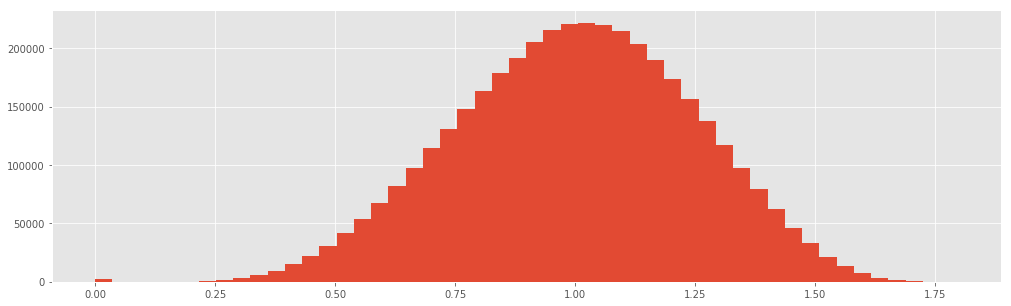

In [23]:
plt.hist(distances.reshape(-1), bins=50);

In [24]:
print('{} distances equal exactly zero.'.format(np.sum(distances == 0)))

2000 distances equal exactly zero.


Why are some distances equal to zero? 

**Your answer here:**

-  The distance from a vector to itself is $0$:
> $dist(u,u)= 1- cos(u,u) = 1 - cos (0) =0$

- The distance between two colinear track_vectors ($u = \lambda v$) is $0$:
> $dist(u,v)= 1- cos(u,v)= 1-cos(u,\lambda u) = 1-cos(u,u)= 1-cos(0)= 1-1=0$ 

### 3.2 Weighted adjacency matrix

From our distances, we want to compute edge weights. If the distance is short, which means the tracks are similar, we want a strong edge. The most widespread kernel for that task is the Gaussian kernel, defined as
$$\mathbf{W}(u,v) = \exp \left( \frac{-d^2(u, v)}{\sigma^2} \right),$$
where $\sigma$ is a parameter which controls the width of the kernel.

Bonus. Can you think of another suitable kernel? **Your answer here.**

Compute below the weight of each edge.

Hints:
* At first, you can set the kernel width, $\sigma$, to the mean value of the distance. (It will preserve the distribution of distances.)
* Don't forget to set the diagonal to zero! We don't want self-connections.

In [25]:
import math
def compute_weight_from_dist(d,var):
    return  math.exp(-math.pow(d,2)/math.pow(var,2))

In [26]:
kernel_width = distances.mean()
weights = np.zeros([dim,dim])
for u in np.arange(dim):
    for v in list(range(u,dim)):
        if u==v : 
            weights[u][v]=0
        else:
            weight = compute_weight_from_dist(distances[u][v],kernel_width)
            weights[u][v] = weight
            weights[v][u] = weight

So we just created a fully connected graph. For our algorithms to be more efficient, we want to sparsify it. There are two main ways to sparsify a graph: i) thresholding all the weights smaller than an $\epsilon$, and ii) keep the $k$ strongest edges for each node. Implement below the second option. You can start with $k=100$.

Hints:
* You can use `np.argsort` to sort the weights.
* Be sure that your weight matrix stays symmetric.
* Look at both the sparsity pattern and the weight distribution as an indication of correctness.

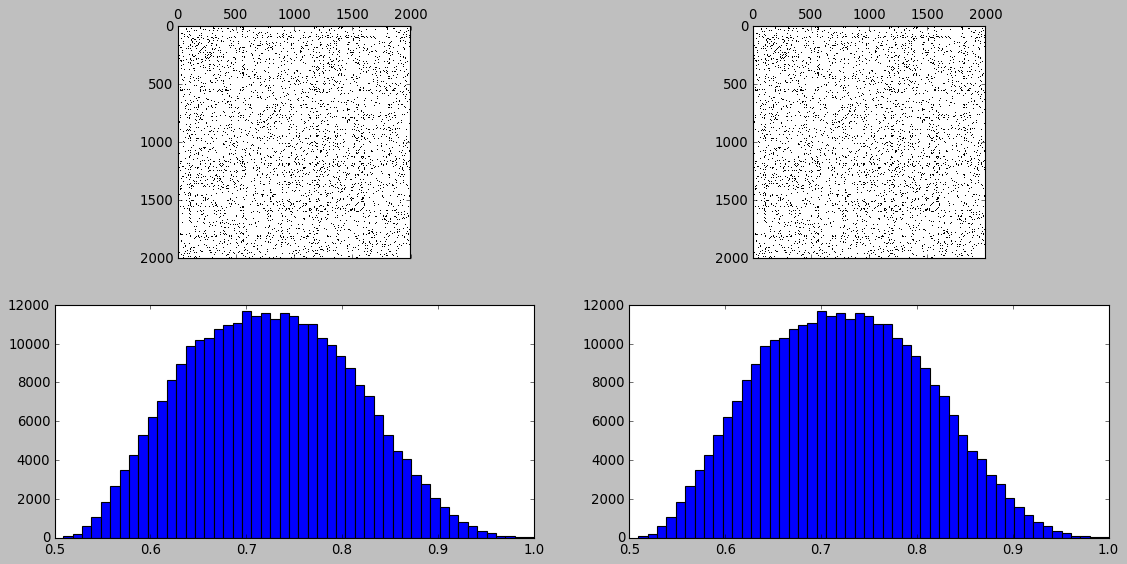

In [28]:
fix, axes = plt.subplots(2, 2, figsize=(17, 8))
def plot(weights, axes):
    plt.style.use("classic")
    axes[0].spy(weights)
    axes[1].hist(weights[weights > 0].reshape(-1), bins=50);
plot(weights, axes[:, 0])

NEIGHBORS = 100

# Your code here.
weights_=weights.copy()
weights = np.zeros([dim,dim])
for u in np.arange(dim):
    to_keep = np.argsort(weights_[u])[-NEIGHBORS:]
    for v in to_keep:
        w = weights_[u][v]
        weights[u][v] = w
        weights[v][u] = w
plot(weights, axes[:, 1])

### 3.3 Bonus: visualize the adjacency matrix

Can you think of a way to observe if the two genres form clusters in the graph we created? You should only use the weight matrix `weights` and the genre labels `tracks['genre']`.

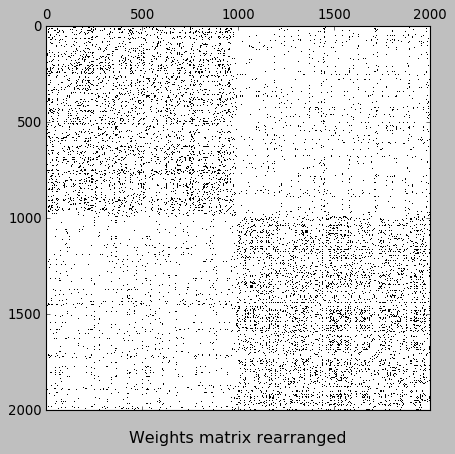

In [29]:
# binary genre
genre = list(map(lambda x: x%2,list(tracks['genre'])))

# build a permutation dict
permutation = dict()
i=0
j=dim-1
while (len(permutation)<dim and i<dim-1 and j>-1): 
    while (genre[i] !=0):
        permutation[i]=i
        i+=1
        
    while (genre[j] !=1):
        permutation[j]=j
        j+=-1
        
    permutation[i]=j
    permutation[j]=i
    i+=1
    j+=-1
    
# rearrange matrix raws
adj_mtx = np.zeros([dim,dim])
for k in np.arange(dim):
    perm_k = permutation[k]
    for l in range(k+1,dim):
        perm_l = permutation[l]
        adj_mtx[k][l] = weights[perm_k][perm_l]
        adj_mtx[l][k] = weights[perm_l][perm_k]
plt.spy(adj_mtx)
plt.title("Weights matrix rearranged",y=-0.1)

### 3.4 Degrees

Compute below the degree vector.

Hints:
* Again, looking at the degree distribution will help you identify any mistake.

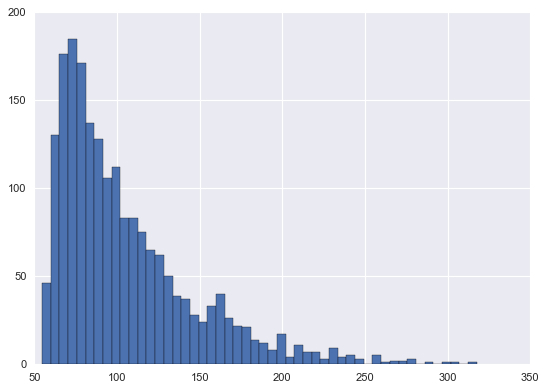

In [30]:
degrees = [np.sum(weights[vertex]) for vertex in np.arange(dim)]
plt.style.use("seaborn")
plt.hist(degrees, bins=50);

### 3.5 Graph Laplacian

We will later need the Fiedler vector. Shall we compute the combinatorial or the normalized Laplacian? 

___
**Your answer here.**

- Fiedler vector is the eigenvector associated to the algebraic connectivity $\lambda_{2}$ of $L_{norm}$. 

- So we need to normalise in order to compute the Fiedler vector. 

- If we aim to have balanced clusters we need a normalised laplacian matrix: **normalized spectral clustring**.
___

Implement your choice below. 

Hints:
* Compare the sparsity pattern of the Laplacian to the one of the weight matrix.

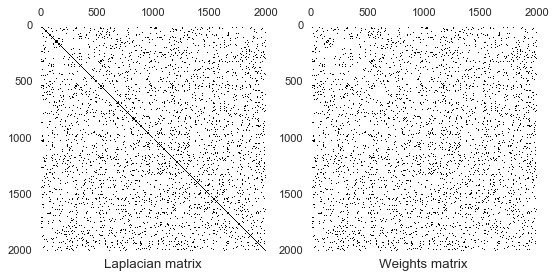

In [31]:
import math
fig, axes = plt.subplots(1,2)

# D to the power -0.5
sqrt_degrees = list(map(lambda x: 1.0/math.sqrt(x),degrees))
D_sqrt = np.diag(sqrt_degrees)

# constuct D
D = np.diag(degrees)

# construct laplacian
laplacian = D - weights

# normalised laplacian
laplacian = D_sqrt.dot(laplacian).dot(D_sqrt)

axes[0].spy(laplacian)
axes[0].set_title("Laplacian matrix",y=-0.1)
axes[1].spy(weights)
axes[1].set_title("Weights matrix",y=-0.1)
plt.margins(1)
plt.show()

___
- We can see that the laplacian and weight matrix are identical in sparsity exept for the diagonal. 
- In fact, the laplacian matrix has the same diagonal as the matrix D that corresponds to the degree of a vertex. 
- Hence, non zeros on the diagonal which is not the case for the weight matrix where there is only zeros on the diagonal (no self loops).
___

For efficient storage and computation, we can store this sparse matrix in a [compressed sparse row (CSR)](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_.28CSR.2C_CRS_or_Yale_format.29) format.

In [32]:
laplacian = sparse.csr_matrix(laplacian)

Compute the number of remaining edges in the graph.

In [33]:
# Number of remainig edge in the graph is half the number of nonzeros in 
#the weight matrix because every edge is represented twice in the weights matrix

remaining_edges = 0.5*len(np.nonzero(weights)[0])
print ("It remains {} edge in the graph".format(remaining_edges))

It remains 145231.0 edge in the graph


## 4 Eigendecomposition of the graph Laplacian

The whole point of spectral graph theory is to compute the eigendecomposition of the Laplacian. We however don't need the full eigendecomposition (a.k.a. the graph Fourier basis) here. Compute the 10 eigenvectors with the smallest eigenvalues with one of the following functions: `np.linalg.eig`, `np.linalg.eigh`, `sparse.linalg.eigs`, `sparse.linalg.eigsh`. Justify your choice.


___
**Your answer here.**
- I use:
    1. `sparse.linalg` package because laplacian matrix is sparse.
    2. Among `sparse.linalg.eigs`, `sparse.linalg.eigsh`, I choose `sparse.linalg.eigsh` because it is a function that computes eighenvalues and eighenvectors for real symetric matrix which is the case of the laplacian matrix.
___

In [34]:
eigenvalues, eigenvectors = sparse.linalg.eigsh(laplacian,k=10,which='SA')

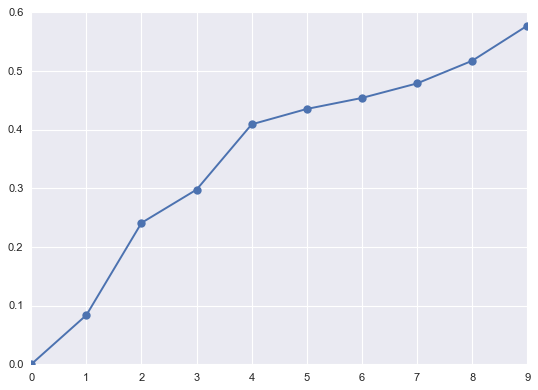

In [35]:
plt.plot(eigenvalues, '.-', markersize=15);

Why can we diagonalize the graph Laplacian in the first place? 
___
**Your answer here.**
- Laplacian matrix is **symmetric matrix**. Hence has n eigenvalues and there exist n linearly independent eigenvectors (because of orthogonality) even if the eigenvalues are not distinct. 
- Therefore, the multiplicity of each eighenvalue is equal to its corresponding vector space dimension. Hence Laplacian is **diagonalizable**.
___
Why are all the eigenvalues real? 
___
**Your answer here.**
- In addition to beeing symetric, Laplacian is a **real matrix**, then all of its eigenvalues are real.
___

Why are all the eigenvalues non-negative?
___
**Your answer here.**
$$ \text{A matrix $M$ is positive semidefinit <=> All eigenvalues of $M$ are positive}$$
- From this proposition and since Laplacian is **positive semi definite** (as shown in the lecture), all eighen values of M are positive.
___

### 4.1 Connectedness

Is the graph connected? Justify. Knowing how we built the graph, can we ensure it is connected?

In [36]:
algebric_connectivity = eigenvalues[1]
if ( algebric_connectivity != 0):
    print ("Since the algebraic connectivity = {} >0, the graph is connected !".format(round(algebric_connectivity,3)))
else:
    print ("0 has multiplicity >1. Hence, the graph is not connected !")

Since the algebraic connectivity = 0.084 >0, the graph is connected !


___
**Your answer here.**
- The eighenvalue $0$ has multiplicity $1$. Hence, the graph is connected.
- There is no ensurance that the graph will be connected by contruction. In fact, by keeping only 100 nearest nodes, the graph can get disconnected. 
- Clearly, the higher $K$ is chosen, the more likely the graph is connected
___

### 4.2 Eigenvector question

What do you expect as the result of the below computation? Justify. Do you get the value you expected? If not, why?

Note that `x @ y` (introduced in Python 3.5) is equivalent to `np.matmul(x, y)`. You should prefer the former as it makes it easier to read formulas.

In [37]:
np.sum(laplacian @ (2 * eigenvectors[:, 0]))

9.0999798842139601e-16

___
**Your answer here.**

- The eighenvector corresponding to the eighenvalue $0$ is the vector $\vec{v}_{\,0}$ satisfying:
$$L\vec{v}_{\,0}=0\vec{v}_{\,0}= \vec{0}      <=>    L2\vec{v}_{\,0}=2*0\vec{v}_{\,0}= 2*\vec{0}=\vec{0}$$
- Therefore, we expect that the sum of the components of $L2\vec{v}_{\,0}$ to be the sum of components of $\vec{0}$. Hence, zero.
- Due to machine accuracy, we dont get $0$ but a very small number.
___

## 5 Visualization and clustering

Finally, let's use the data and graph we prepared. When [exploring data](https://en.wikipedia.org/wiki/Exploratory_data_analysis), it's often useful to visualize an entire dataset. Because for us humans it's hard to look at data in 140 dimensions, we need to somehow reduce the dimensionality to 2 or 3 and visualize the data in this more familiar space. While such a reduction will obviously be destructive, many algorithms have been developed to preserve certain properties.

### 5.1 Principal component analysis (PCA)

[PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) is a standard algorithm to reduce the dimensionality of a dataset. It computes the axes of principal variance and project the data on them. It does only use the features we computed, not the graph. We show it here for comparison. (We use [scikit-learn](http://scikit-learn.org), a very convenient library for Machine Learning.)

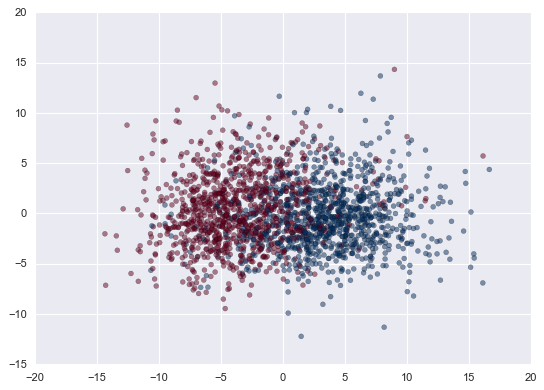

In [38]:
features_pca = decomposition.PCA(n_components=2).fit_transform(features)
genres = preprocessing.LabelEncoder().fit_transform(tracks['genre'])
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=genres, cmap='RdBu', alpha=0.5);

### 5.2 Graph embedding

Instead of using the features directly, we can try to visualize our similarity graph. That graph is embedded in an ambiant space of 140 dimensions (the number of features, that is the number of MFCCs times the number of summary statistics) at first, i.e. each node has a position in an 140-dimensional Euclidean space. Because we cannot visualize such an high-dimensional space, we want to embed the graph in a 2D space.

One way to embed a graph is to use the value of the eigenvectors as coordinates. For the below plot, use the value of the second eigenvector as the x coordinate of a node, and the value of the third eigenvector as the y coordinate. The color is indicated by the genre.

Why don't we use the first eigenvector? 
___
**Your answer here.**
- The first eighenvector is a vector colinear to [1,1,....,1]. In fact, By contruction, we have that every raw corresponding to node $n$ in $L$, has $deg(n)$ at the $n^{th}$ position and -W[i,n] at the $i^{th}$ position. So if we sum all these degrees (sum over $i = 0,1... n$), we get -$deg(n)$ that sums to zero with $deg(n)$.
- Therefore, if we use the first eighenvector, we will get the same x coordinate for all nodes which is not convenient.
___

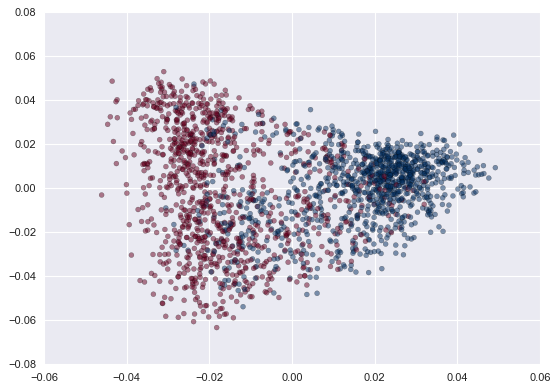

In [39]:
x = eigenvectors[:,1]
y = eigenvectors[:,2]
plt.scatter(x, y, c=genres, cmap='RdBu', alpha=0.5);

See how well this plot summarizes 2GB of data and 2000 tracks! We could now design a playlist generator as a random walk on this similarity graph and visualize its trajectory as it hops from track to track. :)

### 5.3 Clustering

Note how we did not try to build a machine to recognize the musical genre given a track (that would have been a [classification problem](https://en.wikipedia.org/wiki/Statistical_classification)). We did merely try to visualize the data, by means of PCA and a graph embedding algorithm. What does it tell us that genre clearly appears in our visualization?
___
**Your answer here.**

- The fact that genre clearly appears in the vizualization tells us that the two genre of music are distinguishable among different tracks
> **The overall structure (different features) of the truck tells a lot about its genre ! **
___

As such, we can try to cluster the tracks with the Fiedler vector, and look if the (unsupervised) clustering agrees with the *ground truth* genre categorization. Reproduce below the above scatter plot, but with the sign of the Fiedler vector as the color instead of the genre.

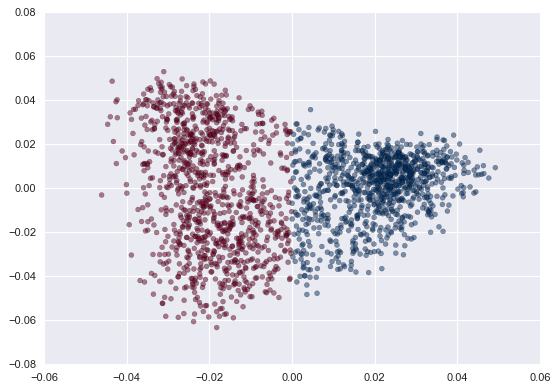

In [40]:
# Change a sign into a label in {0,1}
def sign_to_genre (i):
    if i== -1 : return 0
    else: return 1
labels = list(map(sign_to_genre,np.sign(eigenvectors[:,1])))
plt.scatter(x, y, c=labels, cmap='RdBu', alpha=0.5);

### 5.4 Error rate

How many tracks were wrongly categorized by the Fiedler vector, according to the Rock / Hip-Hop ground truth?

In [41]:
err = len([i for i in np.arange(dim) if labels[i] != genres[i]])
print('{} errors ({:.2%})'.format(err, err/len(labels)))

320 errors (16.00%)


Tune some parameters (e.g. `kernel_width`, `NEIGHBORS`), discard some features (section 2.4), change the distance metric (section 3.1) to get less errors. You should get an error rate below 15% (i.e. less than 300 errors in total). Try to understand the effect of each parameter. After data cleaning, parameter tuning is the other dirty work of a data scientist! Be aware that tuning the parameters on a specific dataset will lead to [overfitting](https://en.wikipedia.org/wiki/Overfitting).

___
We will use sklearn library for **L1-based feature selection¶** described as follows:
> Linear models penalized with the L1 norm have sparse solutions: many of their estimated coefficients are zero. When the goal is to reduce the dimensionality of the data to use with another classifier, they can be used along with feature_selection.SelectFromModel to select the non-zero coefficients. In particular, sparse estimators useful for this purpose are the linear_model.Lasso for regression, and of linear_model.LogisticRegression and svm.LinearSVC for classification
___


In [42]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
iris = load_iris()
X = features.copy()
y = tracks['genre']
X.shape

(2000, 140)

In [43]:
from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)
X_new.shape

(2000, 42)

254 errors (12.70%)


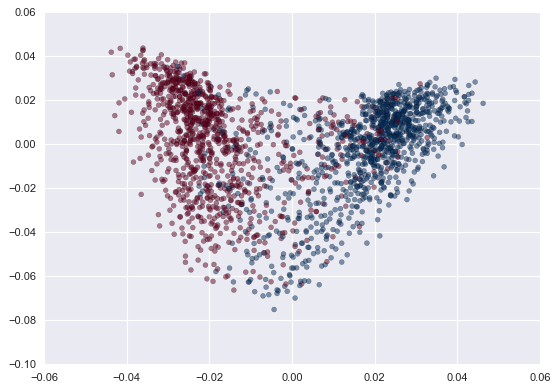

In [44]:
# compute distances
features = pd.DataFrame(X_new)
dim = len(features)
distances = spatial.distance.squareform(spatial.distance.pdist(features.as_matrix(),'cosine'),'tomatrix')

                    
# compute weights
kernel_width = distances.mean()
weights = np.zeros([dim,dim])
for u in np.arange(dim):
    for v in list(range(u,dim)):
        if u==v : 
            weights[u][v]=0
        else:
            weight = compute_weight_from_dist(distances[u][v],kernel_width)
            weights[u][v] = weight
            weights[v][u] = weight
            
# Select best n edges
NEIGHBORS = 100


weights_=weights.copy()
weights = np.zeros([dim,dim])
for u in np.arange(dim):
    to_keep = np.argsort(weights_[u])[-NEIGHBORS:]
    for v in to_keep:
        w = weights_[u][v]
        weights[u][v] = w
        weights[v][u] = w

#degrees
degrees = [np.sum(weights[vertex]) for vertex in np.arange(dim)]

# Normalised laplacian
# D to the power -0.5
sqrt_degrees = list(map(lambda x: 1.0/math.sqrt(x),degrees))
D_sqrt = np.diag(sqrt_degrees)

# constuct D
D = np.diag(degrees)

# construct laplacian
laplacian = D - weights

# normalised laplacian
laplacian = D_sqrt.dot(laplacian).dot(D_sqrt)

# eighen vectors
eigenvalues, eigenvectors = sparse.linalg.eigsh(laplacian,k=10,which='SA')

# Plot
x = eigenvectors[:,1]
y = eigenvectors[:,2]
plt.scatter(x, y, c=genres, cmap='RdBu', alpha=0.5);

# Change a sign into a label in {0,1}
def sign_to_genre (i):
    if i== -1 : return 0
    else: return 1
labels = list(map(sign_to_genre,np.sign(eigenvectors[:,1])))

# get error
err = len([i for i in np.arange(dim) if labels[i] != genres[i]])
print('{} errors ({:.2%})'.format(err, err/len(labels)))

## 6 Conclusion

Among other things, this assignment showed us that a graph can be useful for e.g. visualization or clustering, even when there is none in the original data. One of the design goal of this assignment, while dealing with real data, was to follow the complete Data Science process, from data acquisition to interpretation of the results. The exploitation of the data showed us that a machine can discern musical genres by looking at pairwise distances between spectral features extracted from audio recordings.

### 6.1 Bonus

What is the name of the technique we used to visualize the data in the last two plots? What does it try to preserve when reducing the dimensionality (of the ambiant space) from 140 to 2?
___
**Your answer here.**

**Graph embedding: **
- Mapping a graph on a lower dimentional space (2 in our case)
- Map a weighted graph into a 2 dimentional space such that connected nodes stay as close as possible
___